# AI Mini Project – NutriPic

**LI01 – Group 8**

> 2602069596 - Jack Julius Ryadi Lie
>
> 2602078726 - Albert Yulius Ramahalim
>
> 2602115936 - Lidia Tanaya

This is a Google Colab notebook which contains the prototype of the components used in our AI Mini Project, which are the CNN model for food image classification and the model for food recommendation.

## Food Image Classification System

First, we will start by creating our CNN model that will be used to classify the food images. We will use the pre-trained model InceptionV3, implemented in TensorFlow and Keras.

We prepare the needed libraries.

In [ ]:
from google.colab import drive, files

import collections
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

We mount Google Drive, which will be used to save our CNN model.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


We check the TensorFlow version and whether or not we have enabled our GPU to speed up the training.

In [ ]:
# Check TensorFlow version and GPU used
print(tf.__version__)
print(tf.test.gpu_device_name())

2.15.0
/device:GPU:0


We do several navigations in our file system.

In [ ]:
%cd /content

!mkdir NutriPic
%cd NutriPic

!mkdir input
%cd input

!mkdir food-101
%cd food-101

/content
/content/NutriPic
/content/NutriPic/input
/content/NutriPic/input/food-101


We will be combining two datasets: five classes from the Food-101 dataset (which consists of international foods) and five classes from the Indonesian Food dataset. We proceed to prepare the datasets.

### Preparing the Food-101 Dataset

#### Download and extract the dataset

We download the Food-101 dataset from the internet into our specified folder.

In [ ]:
DATASET_URL = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
DATASET_TAR = 'food-101.tar.gz'
DATASET_DIR = 'food-101'

def get_dataset():
    if DATASET_DIR in os.listdir():
        print('Dataset already exists!')
        return

    print('Downloading dataset...')
    !wget $DATASET_URL

    print('Extracting dataset...')
    !tar xzvf $DATASET_TAR &> /dev/null

    print('Successfully downloaded and extracted')

get_dataset()

--2023-12-16 07:41:24--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2023-12-16 07:41:25--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  17.2MB/s    in 4m 50s  

2023-12-16 07:46:16 (16.4 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

Extracting dataset...
Successfully downloaded and extracted


#### Split the dataset into train and test

Next, we will create our training and test data. To do this, we will create several helper functions: `move_data`, which will move all files listed in `command_file` from `source` to `dest`, as well as `create_train_test_data`, which will create the training and test data in a shared folder with the Indonesian Food dataset.

In [ ]:
def move_data(command_file, source, dest):
    image_list = collections.defaultdict(list)

    with open(command_file, 'r') as cmdf:
        for row in cmdf.readlines():
            path = row.strip().split('/')
            image_list[path[0]].append(path[1] + '.jpg')

    for food_type in image_list.keys():
        print('Moving images of {}'.format(food_type))

        if not os.path.exists(os.path.join(dest, food_type)):
            os.makedirs(os.path.join(dest, food_type))

        for cur_img in image_list[food_type]:
            shutil.copy(os.path.join(source, food_type, cur_img), os.path.join(dest, food_type, cur_img))

    print('Move finished')

def create_train_test_data():
    %cd /

    print('Creating train data...')
    move_data('/content/NutriPic/input/food-101/food-101/meta/train.txt', '/content/NutriPic/input/food-101/food-101/images', 'train')
    print('')

    print('Creating test data...')
    move_data('/content/NutriPic/input/food-101/food-101/meta/test.txt', '/content/NutriPic/input/food-101/food-101/images', 'test')
    print('')

create_train_test_data()

/
Creating train data...
Moving images of apple_pie
Moving images of baby_back_ribs
Moving images of baklava
Moving images of beef_carpaccio
Moving images of beef_tartare
Moving images of beet_salad
Moving images of beignets
Moving images of bibimbap
Moving images of bread_pudding
Moving images of breakfast_burrito
Moving images of bruschetta
Moving images of caesar_salad
Moving images of cannoli
Moving images of caprese_salad
Moving images of carrot_cake
Moving images of ceviche
Moving images of cheesecake
Moving images of cheese_plate
Moving images of chicken_curry
Moving images of chicken_quesadilla
Moving images of chicken_wings
Moving images of chocolate_cake
Moving images of chocolate_mousse
Moving images of churros
Moving images of clam_chowder
Moving images of club_sandwich
Moving images of crab_cakes
Moving images of creme_brulee
Moving images of croque_madame
Moving images of cup_cakes
Moving images of deviled_eggs
Moving images of donuts
Moving images of dumplings
Moving ima

#### Create a subset of the dataset for experimental model training

The five classes we have chosen from the Food-101 dataset to produce an experimental model are `dumplings`, `fish_and_chips`, `steak`, `cup_cakes`, and `sashimi`.

In [ ]:
food_list = [
    'dumplings',
    'fish_and_chips',
    'steak',
    'cup_cakes',
    'sashimi'
]
N = len(food_list)

Finally, we create new `train_sample` and `test_sample` folders to hold our sample datasets, which only consist of the chosen classes. This is done via the `create_dataset_sample` and `create_train_test_sample` functions.

In [ ]:
def create_dataset_sample(food_list, source, dest):
    # Remove old dest folder, if it already exists
    if os.path.exists(dest):
        shutil.rmtree(dest)

    os.makedirs(dest)

    for food_type in food_list:
        print('Adding {} images to sample'.format(food_type))
        shutil.copytree(os.path.join(source, food_type), os.path.join(dest, food_type))

def create_train_test_sample(food_list):
    train_source = 'train'
    train_dest = 'train_sample'

    test_source = 'test'
    test_dest = 'test_sample'

    print('Creating sample with selected food list:')
    print(food_list)

    print('Creating sample train data...')
    create_dataset_sample(food_list, train_source, train_dest)

    print('Sample train data creation finished')

    print('Creating sample test data...')
    create_dataset_sample(food_list, test_source, test_dest)

    print('Sample test data creation finished')

create_train_test_sample(food_list)

Creating sample with selected food list:
['dumplings', 'fish_and_chips', 'steak', 'cup_cakes', 'sashimi']
Creating sample train data...
Adding dumplings images to sample
Adding fish_and_chips images to sample
Adding steak images to sample
Adding cup_cakes images to sample
Adding sashimi images to sample
Sample train data creation finished
Creating sample test data...
Adding dumplings images to sample
Adding fish_and_chips images to sample
Adding steak images to sample
Adding cup_cakes images to sample
Adding sashimi images to sample
Sample test data creation finished


### Preparing the Indonesian Food Dataset

#### Prepare Kaggle API key

Next, we will prepare the Indonesian Food dataset, which we will download from Kaggle. As downloading from Kaggle requires its API key, we first need to prepare and upload it first.

In [ ]:
%cd /content/NutriPic/input

files.upload()

/content/NutriPic/input


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zanite","key":"1c83fa01e9af01611ffb62bfe562d444"}'}

#### Download and extract the dataset

We proceed to install the Kaggle library, after which we will download and extract the dataset.

In [ ]:
# Install Kaggle library
!pip install -q kaggle

# Create directory and modify file preferences
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download and extract the dataset

print('Downloading dataset...')
!kaggle datasets download -d theresalusiana/indonesian-food

print('Extracting dataset...')
!unzip indonesian-food.zip &> /dev/null

print('Successfully downloaded and extracted')

100% 673M/673M [00:36<00:00, 21.0MB/s]
100% 673M/673M [00:36<00:00, 19.5MB/s]
Extracting dataset...
Successfully downloaded and extracted


#### Update the food list

As the dataset only contains five classes, we will add all available classes into our food list and update the list.

In [ ]:
def update_food_list():
    global food_list, N

    orig_path = '/content/NutriPic/input/dataset/train'

    %cd $orig_path
    for dir_name in os.listdir():
        food_list.append(dir_name)

    N = len(food_list)

update_food_list()

/content/NutriPic/input/dataset/train


#### Merge the dataset

We move the Indonesian Food dataset to the shared folders we have prepared beforehand.

In [ ]:
def move_indonesian_food_data(dataset_type):
    orig_path = '/content/NutriPic/input/dataset/{}'.format(dataset_type)
    dest = '/{}_sample'.format(dataset_type)

    %cd $orig_path

    for dir_name in os.listdir():
        full_path = os.path.abspath(dir_name)
        !cp -r $full_path $dest

move_indonesian_food_data('train')
move_indonesian_food_data('test')

/content/NutriPic/input/dataset/train
/content/NutriPic/input/dataset/test


### Model Training

After the datasets have been prepared, we can finally proceed with training our CNN model.

#### Clear Keras session

We need to first clear the session to avoid any potential conflicts with other models we have created.

In [ ]:
%cd /
K.clear_session()

/


#### Prepare dataset

We first look at an overview of the number of train and test samples.

In [ ]:
print('Total number of train samples: ', end='')
!find train_sample -type d -or -type f -printf '.' | wc -c

print('Total number of test samples: ', end='')
!find test_sample -type d -or -type f -printf '.' | wc -c

Total number of train samples: 11024
Total number of test samples: 2163


We define several constants regarding the train data, image size, and batch size.

In [ ]:
N_classes = N
img_width, img_height = 299, 299

train_data_dir = 'train_sample'
test_data_dir = 'test_sample'

nb_train_samples = 11024
nb_test_samples = 2163

batch_size = 16

#### Data augmentation

We set up several functions to augment the training data. The augmentations that we do include rescaling, shearing, zooming, and horizontal flipping.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1.0/255
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 11024 images belonging to 10 classes.
Found 2163 images belonging to 10 classes.


#### Model architecture and compilation

We create a new InceptionV3 model without the top fully-connected layers. This is because the top layer has an output of $1000$ classes, while we only need to output $N = 10$ classes. To reduce the size of our model, we will proceed to add our own top layers above the InceptionV3 models:

- The `GlobalAveragePooling2D` layer, which performs dimensional reduction on the original output of the InceptionV3 layers, creating a global summary of the features.

- The `Dense` layer with $128$ units and ReLU activation function, which introduces non-linearity to the model.

- The `Drouput` layer with a dropout rate of $0.2$, which prevents overfitting by randomly dropping (setting to $0$) a portion of the input units.

- The final `Dense` layer named `predictions`, which uses a softmax activation function to perform multi-class classification. We use the `l2` kernel regularizer with a weight decay of $0.005$.

In [ ]:
inception = InceptionV3(
    weights = 'imagenet',
    include_top = False
)

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(
    N,
    kernel_regularizer = l2(0.005),
    activation = 'softmax'
)(x)

model = Model(
    inputs = inception.input,
    outputs = predictions
)

87910968/87910968 [==============================] - 5s 0us/step


Then, we compile our model. We use the stochastic gradient descent (SGD) optimizer with a learning rate of $0.0001$ and momentum of $0.9$. We use the `categorical_crossentropy` method to calculate the loss, and we use `accuracy` as our main metric, both of which are common in multi-class classification problems.

In [ ]:
model.compile(
    optimizer = SGD(learning_rate=0.0001, momentum=0.9),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

#### Model training

Finally, we are ready to train our CNN model. We use callbacks to save the best model based on the validation performance. We choose to train our model over $25$ epochs.

In [ ]:
checkpointer = ModelCheckpoint(
    filepath = 'best_model_class.hdf5',
    verbose = 1,
    save_best_only = True
)

csv_logger = CSVLogger('history_class.log')

history_class = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    validation_data = test_generator,
    validation_steps = nb_test_samples // batch_size,
    epochs = 25,
    verbose = 1,
    callbacks = [csv_logger, checkpointer]
)

model.save('model_trained_class.hdf5')

Epoch 1/25
689/689 [==============================] - ETA: 0s - loss: 1.5576 - accuracy: 0.5536
Epoch 1: val_loss improved from inf to 0.76338, saving model to best_model_class.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


689/689 [==============================] - 365s 472ms/step - loss: 1.5576 - accuracy: 0.5536 - val_loss: 0.7634 - val_accuracy: 0.8824
Epoch 2/25
689/689 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.8366
Epoch 2: val_loss improved from 0.76338 to 0.35283, saving model to best_model_class.hdf5
689/689 [==============================] - 329s 477ms/step - loss: 0.6872 - accuracy: 0.8366 - val_loss: 0.3528 - val_accuracy: 0.9394
Epoch 3/25
689/689 [==============================] - ETA: 0s - loss: 0.4865 - accuracy: 0.8857
Epoch 3: val_loss improved from 0.35283 to 0.26716, saving model to best_model_class.hdf5
689/689 [==============================] - 329s 477ms/step - loss: 0.4865 - accuracy: 0.8857 - val_loss: 0.2672 - val_accuracy: 0.9551
Epoch 4/25
689/689 [==============================] - ETA: 0s - loss: 0.4032 - accuracy: 0.9083
Epoch 4: val_loss improved from 0.26716 to 0.22929, saving model to best_model_class.hdf5
689/689 [============================

We save the model result to Google Drive for future use.

In [ ]:
!cp best_model_class.hdf5 /content/drive/MyDrive/food-image-classification
!cp history_class.log /content/drive/MyDrive/food-image-classification
!cp model_trained_class.hdf5 /content/drive/MyDrive/food-image-classification

### Model Assessment

#### Accuracy and loss

We will perform an assessment on the model's accuracy and loss over the $25$ epochs by plotting the results as follows.

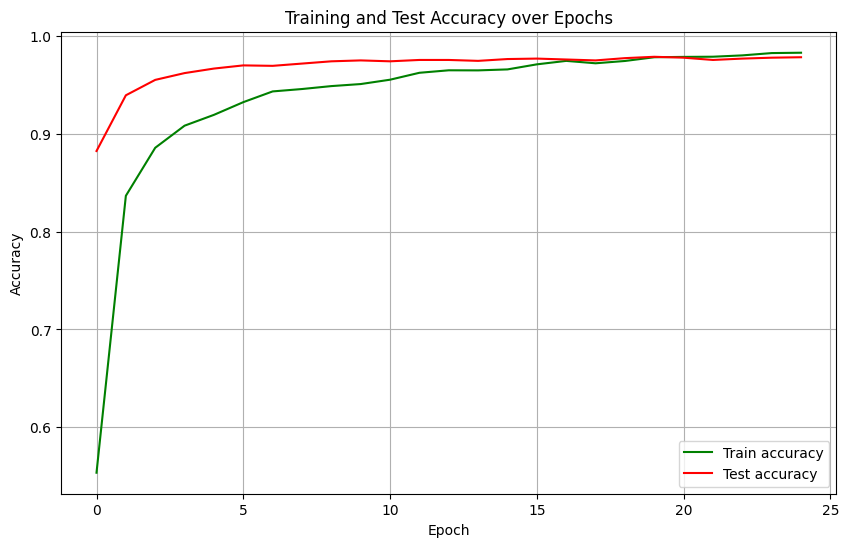

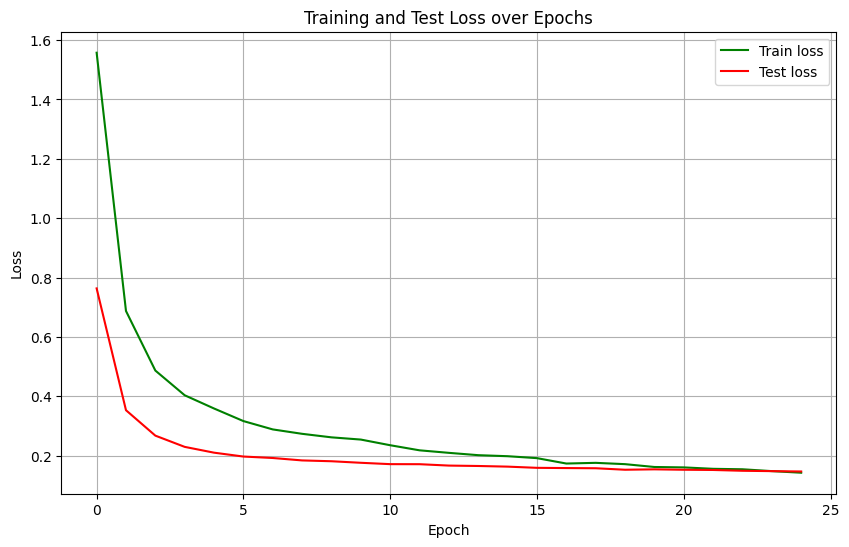

In [ ]:
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.title('Training and Test Accuracy over Epochs')
    plt.plot(history.history['accuracy'], color='green')
    plt.plot(history.history['val_accuracy'], color='red')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train accuracy', 'Test accuracy'], loc='best')
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.title('Training and Test Loss over Epochs')
    plt.plot(history.history['loss'], color='green')
    plt.plot(history.history['val_loss'], color='red')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Test loss'], loc='best')
    plt.grid(True)
    plt.show()

plot_accuracy(history_class)
plot_loss(history_class)

#### Using the trained model to predict classes of images from the internet

We will experiment on using our model to perform classification over novel data from the internet.

First, we load our model.

In [ ]:
K.clear_session()
model_best = load_model('model_trained_class.hdf5', compile=False)

We create a function to predict the classes of a list of images and show them using Matplotlib.

In [ ]:
def predict_images(model, images):
    for current_image in images:
        current_image = image.load_img(current_image, target_size=(299, 299))
        current_image = image.img_to_array(current_image)
        current_image = np.expand_dims(current_image, axis=0)
        current_image /= 255.0

        prediction = model.predict(current_image)
        index = np.argmax(prediction)
        food_list.sort()
        pred_value = food_list[index]

        plt.imshow(current_image[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

Finally, we download the images from the internet into an `internet_testing` folder, and perform the predictions.

/internet_testing
1/1 [==============================] - 0s 26ms/step


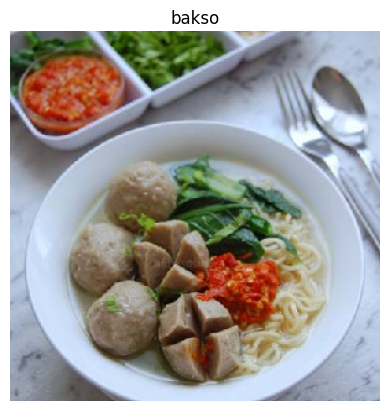

1/1 [==============================] - 0s 25ms/step


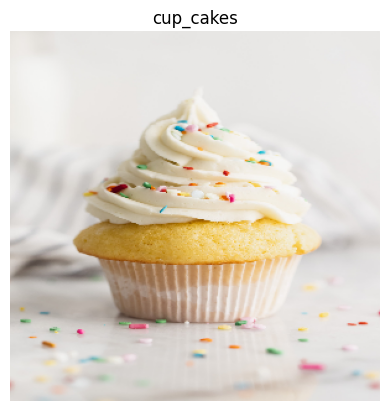

1/1 [==============================] - 0s 24ms/step


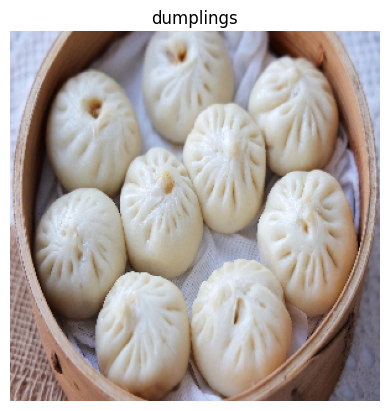

1/1 [==============================] - 0s 29ms/step


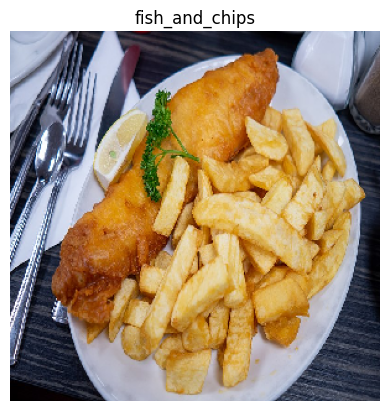

1/1 [==============================] - 0s 29ms/step


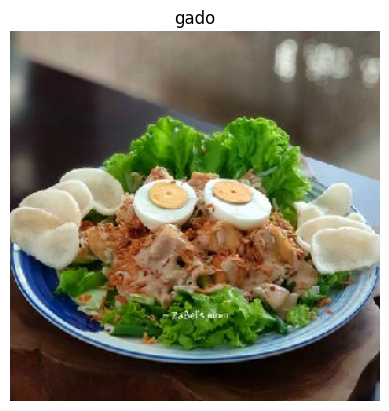

1/1 [==============================] - 0s 27ms/step


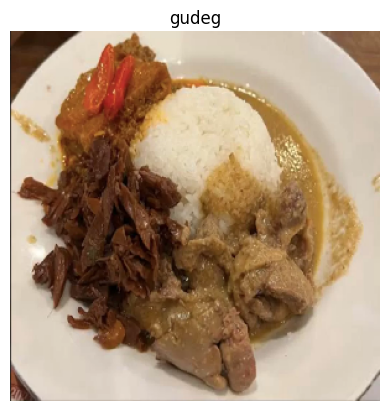

1/1 [==============================] - 0s 26ms/step


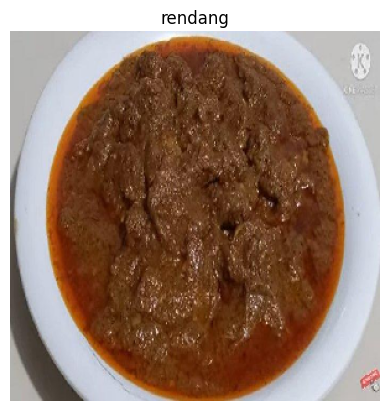

1/1 [==============================] - 0s 44ms/step


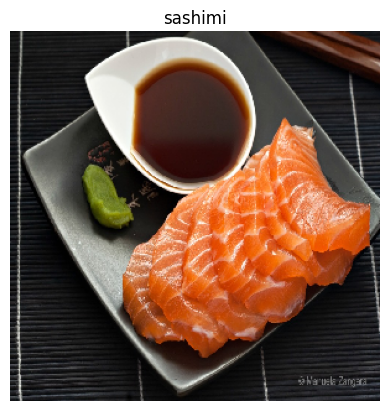

1/1 [==============================] - 0s 38ms/step


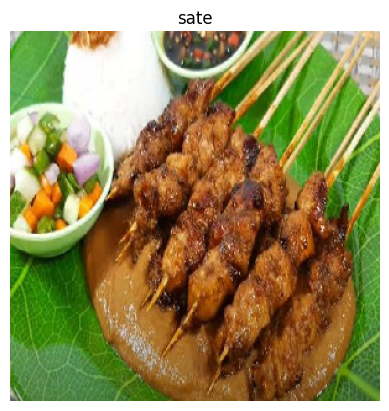

1/1 [==============================] - 0s 31ms/step


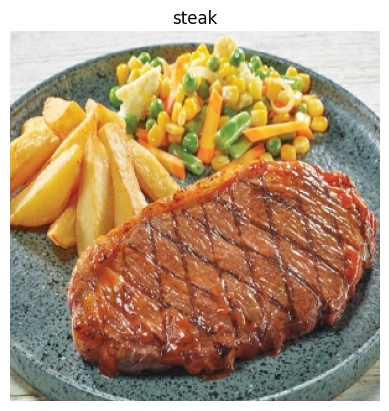

In [ ]:
!mkdir internet_testing
%cd internet_testing

internet_image_sources = {
    'bakso': 'https://img-global.cpcdn.com/recipes/ae987249562a1a55/400x400cq70/photo.jpg',
    'cup_cakes': 'https://bromabakery.com/wp-content/uploads/2023/03/Single-Serve-Vanilla-Cupcake.jpg',
    'dumpling': 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Xiaolongbao-breakfast.jpg/1200px-Xiaolongbao-breakfast.jpg',
    'fish_and_chips': 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Fish_and_chips_blackpool.jpg/800px-Fish_and_chips_blackpool.jpg',
    'gado': 'https://img-global.cpcdn.com/recipes/d673616eeeb1cbf5/400x400cq70/photo.jpg',
    'gudeg': 'https://static.promediateknologi.id/crop/0x0:0x0/0x0/webp/photo/indizone/2022/07/28/mnsdrpZ/gudeg-sagan-gudeg-jogja-bercita-rasa-gurih-yang-berawal-dari-warung-kaki-lima18.jpg',
    'rendang': 'https://asset-2.tstatic.net/bangka/foto/bank/images/20230625-resep-rendang-daging-kambing.jpg',
    'sashimi': 'https://www.glorimelamine.com/wp-content/uploads/Resep-Masak-Shashimi-Sederhana-di-Rumah.jpg',
    'sate': 'https://asset-2.tstatic.net/jambi/foto/bank/images/resep-sate-ayam-manis.jpg',
    'steak': 'https://images.bisnis.com/posts/2022/10/04/1584210/abuba_steak.jpg'
}

images = []

for key in internet_image_sources.keys():
    image_name = key + '.jpg'
    image_url = internet_image_sources[key]

    !wget -O $image_name $image_url &> /dev/null
    images.append(image_name)

predict_images(model_best, images)

## Food to Nutrition Conversion

Before we can give recommendations to the user about what food they must consume, we must first gather data about the nutrition of each food item in our dataset. We will do so by using the Nutritionix API.

We consider four important nutrition components: Carbohydrate, Protein, Fat, and Fiber.

Below is the code to call the Nutritionix API. As calling 101 requests is expensive and takes a good portion of the daily limit of 200 requests, we only ran the following code once and stored the request in a CSV file.

We have uploaded the CSV file to GitHub [here](https://raw.githubusercontent.com/ZaniteA/food-101-nutrition-data/main/nutrition_data.csv).

### Food-101 Food Categories List (click to expand)

In [ ]:
food_categories = [
    'chocolate_cake',
    'baklava',
    'eggs_benedict',
    'club_sandwich',
    'mussels',
    'spaghetti_bolognese',
    'bread_pudding',
    'shrimp_and_grits',
    'escargots',
    'onion_rings',
    'foie_gras',
    'red_velvet_cake',
    'donuts',
    'cup_cakes',
    'guacamole',
    'sashimi',
    'bruschetta',
    'beef_carpaccio',
    'nachos',
    'chocolate_mousse',
    'ice_cream',
    'bibimbap',
    'hot_and_sour_soup',
    'fish_and_chips',
    'panna_cotta',
    'tacos',
    'dumplings',
    'cheese_plate',
    'falafel',
    'crab_cakes',
    'gnocchi',
    'greek_salad',
    'macarons',
    'spaghetti_carbonara',
    'oysters',
    'peking_duck',
    'chicken_curry',
    'hot_dog',
    'caprese_salad',
    'pancakes',
    'french_fries',
    'pulled_pork_sandwich',
    'beef_tartare',
    'caesar_salad',
    'tuna_tartare',
    'chicken_quesadilla',
    'hummus',
    'grilled_salmon',
    'lobster_bisque',
    'pho',
    'scallops',
    'macaroni_and_cheese',
    'waffles',
    'pad_thai',
    'miso_soup',
    'takoyaki',
    'lobster_roll_sandwich',
    'fried_calamari',
    'filet_mignon',
    'churros',
    'poutine',
    'apple_pie',
    'frozen_yogurt',
    'ramen',
    'pizza',
    'french_onion_soup',
    'prime_rib',
    'breakfast_burrito',
    'baby_back_ribs',
    'gyoza',
    'strawberry_shortcake',
    'spring_rolls',
    'cannoli',
    'lasagna',
    'paella',
    'beignets',
    'hamburger',
    'fried_rice',
    'pork_chop',
    'chicken_wings',
    'deviled_eggs',
    'sushi',
    'beet_salad',
    'omelette',
    'ravioli',
    'ceviche',
    'croque_madame',
    'garlic_bread',
    'edamame',
    'huevos_rancheros',
    'tiramisu',
    'steak',
    'grilled_cheese_sandwich',
    'seaweed_salad',
    'french_toast',
    'creme_brulee',
    'clam_chowder',
    'risotto',
    'carrot_cake',
    'samosa',
    'cheesecake'
]

### API Requests

We first import the required libraries.

In [ ]:
import requests
import json
import pandas as pd

Next, we prepare the requirements needed to request the API, including the API ID, key, and request headers. The function `get_api_response` performs one query call of one food item. The results are then tidied up by `get_nutrition_data` and consolidated into one final table.

In [ ]:
# Running this code uses 101 API requests so it can only be done once per day

api_id = 'a022b1b0'
api_key = '336523946d66b7ae76e20e3295b6f68c'
url = 'https://trackapi.nutritionix.com/v2/natural/nutrients'

headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'x-app-id': api_id,
    'x-app-key': api_key,
    'x-remote-user-id': '0'
}

def get_api_response(food_name):
    query = {
        'query' : food_name
    }

    response = requests.request("POST", url, headers=headers, data=query).json()
    response_foods = response['foods'][0]
    return response_foods

def get_nutrition_data(food_name):
    # [food name, carbohydrate, protein, fat, fiber]
    print(food_name)

    response_dict = get_api_response(food_name)

    return [
       food_name,
       response_dict['nf_total_carbohydrate'],
       response_dict['nf_protein'],
       response_dict['nf_total_fat'],
       response_dict['nf_dietary_fiber']
    ]

nutrition_table = []
for food_name in food_categories:
    nutrition_table.append(get_nutrition_data(food_name))

chocolate_cake
baklava
eggs_benedict
club_sandwich
mussels
spaghetti_bolognese
bread_pudding
shrimp_and_grits
escargots
onion_rings
foie_gras
red_velvet_cake
donuts
cup_cakes
guacamole
sashimi
bruschetta
beef_carpaccio
nachos
chocolate_mousse
ice_cream
bibimbap
hot_and_sour_soup
fish_and_chips
panna_cotta
tacos
dumplings
cheese_plate
falafel
crab_cakes
gnocchi
greek_salad
macarons
spaghetti_carbonara
oysters
peking_duck
chicken_curry
hot_dog
caprese_salad
pancakes
french_fries
pulled_pork_sandwich
beef_tartare
caesar_salad
tuna_tartare
chicken_quesadilla
hummus
grilled_salmon
lobster_bisque
pho
scallops
macaroni_and_cheese
waffles
pad_thai
miso_soup
takoyaki
lobster_roll_sandwich
fried_calamari
filet_mignon
churros
poutine
apple_pie
frozen_yogurt
ramen
pizza
french_onion_soup
prime_rib
breakfast_burrito
baby_back_ribs
gyoza
strawberry_shortcake
spring_rolls
cannoli
lasagna
paella
beignets
hamburger
fried_rice
pork_chop
chicken_wings
deviled_eggs
sushi
beet_salad
omelette
ravioli
cevich

Some Indonesian foods were missing from the database, so we needed to search them up in other sources and add them manually. This is possible as there are only five items.

In [ ]:
nutrition_table.append(['bakso', 15, 15, 12, 2.7])
nutrition_table.append(['gado', 26.28, 17.22, 17.86, 6.9])
nutrition_table.append(['gudeg', 19, 1.5, 3.1, 1.3])
nutrition_table.append(['rendang', 9.9, 36, 27, 1.2])
nutrition_table.append(['sate', 22, 22, 29, 2.5])

We export the data into a CSV file. Some fields were empty, which we fixed in the CSV file uploaded to GitHub.

In [ ]:
column_names = ['Food name', 'Carbohydrate', 'Protein', 'Fat', 'Fiber']

dataframe = pd.DataFrame(nutrition_table, columns=column_names)
display(dataframe)

dataframe.to_csv('nutrition_data.csv', index=False, header=True)

,Food name,Carbohydrate,Protein,Fat,Fiber
0,chocolate_cake,57.60,3.79,21.85,2.40
1,baklava,29.41,5.46,19.83,1.83
2,eggs_benedict,30.18,30.15,54.85,2.17
3,club_sandwich,42.24,55.83,46.16,3.20
4,mussels,6.28,20.23,3.81,0.00
...,...,...,...,...,...
101,bakso,15.00,15.00,12.00,2.70
102,gado,26.28,17.22,17.86,6.90
103,gudeg,19.00,1.50,3.10,1.30
104,rendang,9.90,36.00,27.00,1.20


## Food Recommendation System

Now that we have the data of each food item's nutritional value, we can give recommendations to the user.

We view the four important nutritions as a dimension in our feature space. The user starts at $(0, 0, 0, 0)$ and will achieve their target daily intake at $(1, 1, 1, 1)$. Each food item is a vector that will be applied to the user's position when consumed.

We pick $5$ best food items that brings the user closest to the target. To do this, we use the Euclidean distance metric. However, we ignore "overshooting" the target to reduce inaccuracy (i.e. a user that has eaten enough fats but hasn't gotten enough fiber should be recommended foods high on fiber, not merely low on fat). Therefore, if $\mathbf{u}$ is the current user's state and $\mathbf{f}$ is the food item, the distance metric is
$$
d(\mathbf{f}) = \sqrt{\sum_{i = 1}^{4} (\max(1 - u_i - f_i), 0)^2}.
$$

We will proceed to implement the described system. First, we import the needed libraries.

In [ ]:
import numpy as np
import pandas as pd

We set the constants that we will use.

We set the carbohydrate, protein, fat, and fiber target to be $275$, $50$, $61$, and $30$ grams respectively. However, note that in the final product, these values may vary depending on the user's characteristics.

We also set the target vector $(1, 1, 1, 1)$, the column labels, the recommendation count, and the URL of the CSV file on GitHub that contains the nutrient data.

In [ ]:
carbohydrate_target = 275
protein_target      = 50
fat_target          = 61
fiber_target        = 30

target_vector = np.ones(4)
column_labels = ['Carbohydrate', 'Protein', 'Fat', 'Fiber']

recommendation_count = 5

nutrients_url = 'https://raw.githubusercontent.com/ZaniteA/food-101-nutrition-data/main/nutrition_data.csv'

We load the nutrients dataset and convert it into a dictionary for ease of search. We simultaneously normalize the values according to the target values during this process.

In [ ]:
nutrients_dataset = pd.read_csv(nutrients_url)

nutrient_dict = {}
for index, row in nutrients_dataset.iterrows():
    nutrient_dict[row['Food name']] = np.array([
        min(1.0, row['Carbohydrate'] / carbohydrate_target),
        min(1.0, row['Protein'] / protein_target),
        min(1.0, row['Fat'] / fat_target),
        min(1.0, row['Fiber'] / fiber_target)
    ])

Finally, we can implement the system with the distance metric described above.

- `clear_food_history` clears the list of food items the user has eaten. This would be performed during the time where the day changes in the app.

- `add_food_item` adds a new item to the list.

- `get_recommendation` fetches the recommendations according to the current user's state, which can be computed from the food history list.

In [ ]:
food_history = []

def clear_food_history():
    global food_history
    food_history.clear()
    print('Cleared history')
    print()

def add_food_item(food_name):
    global food_history

    if food_name in nutrient_dict:
        food_history.append(food_name)
        print('Added {} to food list'.format(food_name))
    else:
        print('Food with name {} not found'.format(food_name))
    print()

def get_recommendation():
    global food_history

    feature_vector = np.zeros(4)
    for item in food_history:
        feature_vector += nutrient_dict[item]

    diff = feature_vector - target_vector
    min_nutrient = np.argmin(diff)

    if (diff[min_nutrient] >= 0):
        print('Congratulations! You have fulfilled your body\'s needs for the day!')
        print()
        return
    else:
        print('You need to get some more {} for the day!'.format(column_labels[min_nutrient]))

    food_contrib = []
    for key in nutrient_dict.keys():
        food_contrib.append([np.linalg.norm(np.maximum(-nutrient_dict[key] - diff, np.zeros(4))), key])

    food_contrib.sort()

    print('Here are some food recommendations to fulfill your body\'s needs:')
    for i in range(recommendation_count):
        print('{}. {}'.format(i+1, food_contrib[i][1]))
    print()

We demonstrate the system with the following code.

In [ ]:
clear_food_history()
get_recommendation()
add_food_item('hamburger')
add_food_item('caesar_salad')
get_recommendation()
add_food_item('rubber_bands')
add_food_item('bibimbap')
get_recommendation()

clear_food_history()
get_recommendation()
add_food_item('gado')
get_recommendation()

Cleared history

You need to get some more Carbohydrate for the day!
Here are some food recommendations to fulfill your body's needs:
1. chicken_quesadilla
2. spaghetti_carbonara
3. ramen
4. bibimbap
5. huevos_rancheros

Added hamburger to food list

Added caesar_salad to food list

You need to get some more Fiber for the day!
Here are some food recommendations to fulfill your body's needs:
1. spaghetti_carbonara
2. bibimbap
3. spaghetti_bolognese
4. onion_rings
5. ramen

Food with name rubber_bands not found

Added bibimbap to food list

You need to get some more Fiber for the day!
Here are some food recommendations to fulfill your body's needs:
1. huevos_rancheros
2. spaghetti_bolognese
3. spaghetti_carbonara
4. onion_rings
5. chicken_quesadilla

Cleared history

You need to get some more Carbohydrate for the day!
Here are some food recommendations to fulfill your body's needs:
1. chicken_quesadilla
2. spaghetti_carbonara
3. ramen
4. bibimbap
5. huevos_rancheros

Added gado to food l